# (MultiFiT) Portuguese Bidirectional Language Model (LM) from scratch
### (architecture 4 QRNN with 1550 hidden parameters by layer, SentencePiece tokenizer and hyperparameters from the MultiFiT method)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-portuguese-language-model-980c8ec75362)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the architecture QRNN and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. Therefore, they have been used in this notebook to train a Portuguese Bidirectional Language Model on a Wikipedia corpus of 100 millions tokens. 

More, the hyperparameters values given at the end of the article have been used, too.

**Wikipedia corpus**
- download: 193 651 articles of 182 536 221 tokens
- used: 166 580 articles of 100 255 322 tokens

**Hyperparameters values**
- (batch size) bs = 50
- (QRNN) 4 QRNN (default: 3) with 1550 hidden parameters each one (default: 1152)
- (SentencePiece) vocab of 15000 tokens
- (dropout) mult_drop = 0
- (weight decay) wd = 0.01
- (number of training epochs) 10 epochs

## Results

The Portuguese Bidirectional Language Model with the [MultiFiT](https://arxiv.org/abs/1909.04761) configuration performs well in both directions (see following results).

**To be noticed**: we could have trained on more epochs both the forward and backward models but we decided to follow the MultiFiT training method based on the tests done by Jeremy Howard and his fastai team that shows that a Text Classifier fine-tuned with a specialized LM itself fine-tuned with a general LM performs better if the general LM was not trained too much. 

- forward : (accuracy) 39.68% | (perplexity) 21.76
- backward: (accuracy) 43.67% | (perplexity) 22.16

**To be improved**

The lost function FlattenedLoss of LabelSmoothingCrossEntropy should be tested as it is used in the MultiFiT method (see the notebook [lm3-portuguese-classifier-TCU-jurisprudencia.ipynb](https://github.com/piegu/language-models/blob/master/lm3-portuguese-classifier-TCU-jurisprudencia.ipynb) to get the code).

## Initialisation

In [1]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# batch size to be choosen according to your GPU 
# bs=48
# bs=24
bs=50

In [3]:
torch.cuda.set_device(0)

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.57
cuda: True


In [5]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-9-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.168-1+deb9u5 (2019-08-11)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/tutorials/fastai/course-nlp
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:


In [6]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [7]:
lang = 'pt'

In [8]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']

## Data (Portuguese wikipedia)

### Download data

In [9]:
from nlputils import split_wiki,get_wiki
from nlputils2 import *

In [10]:
%%time
get_wiki(path,lang)

/home/jupyter/.fastai/data/ptwiki/ptwiki already exists; not downloading
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 273 µs


This function splits the single wikipedia file into a separate file per article. This is often easier to work with.

In [11]:
%%time
split_wiki2(path,lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
CPU times: user 14 s, sys: 5.58 s, total: 19.5 s
Wall time: 21.4 s


PosixPath('/home/jupyter/.fastai/data/ptwiki/docs')

In [12]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/ptwiki/models'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/corpus_100000000_old'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/pt_databunch_corpus_100'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/pt_databunch_corpus_100_bwd'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/docs'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/ptwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/docs_old'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/wikiextractor'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/ptwiki'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/ptwiki-latest-pages-articles.xml'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/log')]

In [13]:
!head -n4 {path}/{name}

<doc id="220" url="https://pt.wikipedia.org/wiki?curid=220" title="Astronomia">
Astronomia

Astronomia é uma ciência natural que estuda corpos celestes (como estrelas, planetas, cometas, nebulosas, aglomerados de estrelas, galáxias) e fenômenos que se originam fora da atmosfera da Terra (como a radiação cósmica de fundo em micro-ondas). Preocupada com a evolução, a física, a química e o movimento de objetos celestes, bem como a formação e o desenvolvimento do universo.


In [14]:
%%time
folder = "docs"
clean_files(path,folder)

In [15]:
dest = path/'docs'
dest.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/ptwiki/docs/Pac_Man__personagem_.txt'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/docs/Jo_o_Comneno_Vatatzes.txt'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/docs/Lupo_Servato.txt'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/docs/Maom_.txt'),
 PosixPath('/home/jupyter/.fastai/data/ptwiki/docs/Ilha_de_S_o_Sim_o__Galiza_.txt')]

In [16]:
!head -n4 {dest.ls()[0]}

Pac-Man é o personagem principal da franquia de jogos eletrônicos criada pela Namco, introduzido pelo jogo de arcade Pac-Man de 1980. É marcado como um dos personagens mais icônicos dos games desde sua estréia, recebendo inúmeros jogos inspirados no mesmo e programas de TV. O personagem também serve como mascote oficial da empresa Namco.

Pac-Man a princípio era um círculo amarelo com uma boca que constantemente abria e fechava. Somente a partir da primeira série animada lançada em 1982 é que o personagem ganhou uma aparência humanoide tendo braços e pernas com luvas e sapatos, além de olhos e um nariz, e também um chapéu marrom. Essa mesma aparência serviu de imagem promocional para os demais jogos lançados na época, porém sem o chapéu do desenho. Com o tempo seus olhos foram se alterando e passaram a ser duas bolinhas pretas com uma abertura nos lados típico de desenhos clássicos.



### Size of downloaded data in the docs folder

In [17]:
%%time
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

193651 files - 182536221 tokens
CPU times: user 17.1 s, sys: 3.56 s, total: 20.6 s
Wall time: 1min 17s


### Create a corpus of about 100 millions of tokens

In [18]:
%%time
path_corpus = get_corpus(dest, path, num_tokens, obj_tokens=1e8)

files copied to the new corpus folder: /home/jupyter/.fastai/data/ptwiki/corpus_100000000
CPU times: user 6.88 s, sys: 5.79 s, total: 12.7 s
Wall time: 19.9 s


In [19]:
%%time
# VERIFICATION of the number of words in the corpus folder
num_files_corpus, num_tokens_corpus = get_num_tokens(path_corpus)
print(f'{num_files_corpus} files - {num_tokens_corpus} tokens')

166580 files - 100255322 tokens
CPU times: user 10.9 s, sys: 2.16 s, total: 13.1 s
Wall time: 55.3 s


In [20]:
# change name of the corpus 
!mv {path}/'corpus_100000000' {path}/'corpus2_100'

## Databunch

In [9]:
dest = path/'corpus2_100'

### Forward

In [22]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=1))

CPU times: user 39min 42s, sys: 24.9 s, total: 40min 7s
Wall time: 20min 17s


In [23]:
data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit')

In [24]:
len(data.vocab.itos),len(data.train_ds)

(15000, 149922)

In [25]:
len(data.vocab.itos),len(data.vocab.stoi)

(15000, 15000)

In [26]:
data.train_ds.x[1]

Text ▁xxbos ▁xxmaj ▁joão ▁xxmaj ▁com ne no ▁xxmaj ▁ va ta tz es ▁( ), ▁ou ▁simplesmente ▁xxmaj ▁joão ▁xxmaj ▁com ne no ▁ou ▁xxmaj ▁joão ▁xxmaj ▁ va ta tz es , ▁foi ▁um ▁importante ▁político ▁e ▁líder ▁militar ▁bizantino ▁durante ▁os ▁reinado s ▁de ▁e ▁ . ▁xxmaj ▁ele ▁nasceu ▁por ▁volta ▁de ▁e ▁morreu ▁de ▁causas ▁naturais ▁durante ▁uma ▁revolta ▁que ▁ele ▁mesmo ▁iniciou ▁contra ▁em ▁ . ▁xxmaj ▁joão ▁xxmaj ▁com ne no ▁xxmaj ▁ va ta tz es ▁era ▁filho ▁do ▁se bas to hi per ta to ▁xxmaj ▁teodoro ▁xxmaj ▁ va ta tz es ▁e ▁da ▁por fi ro gê nita ▁xxmaj ▁eu dó xia ▁xxmaj ▁com ne na , ▁princesa ▁filha ▁do ▁imperador ▁e ▁xxmaj ▁irene ▁da ▁xxmaj ▁hungria . ▁xxmaj ▁teodoro ▁era ▁um ▁dos ▁" hom ens - novo s " ▁alça dos ▁por ▁xxmaj ▁joão ▁xxup ▁ii ; ▁a ▁família ▁xxmaj ▁ va ta tz es ▁não ▁estava ▁entre ▁as ▁mais ▁proeminente s ▁da ▁aristocracia ▁bizantina , ▁mesmo ▁sendo ▁muito ▁importante ▁nas ▁cerca nia s ▁de ▁xxmaj ▁adrian ópolis , ▁na ▁xxmaj ▁ tr ácia . ▁xxmaj ▁os ▁pais ▁de ▁xxmaj ▁joão ▁se ▁casa 

### Backward

In [27]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()
            .databunch(bs=bs, num_workers=1, backwards=True))

data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit_bwd')

CPU times: user 38min 20s, sys: 25 s, total: 38min 45s
Wall time: 20min 19s


## Training

### Forward

In [10]:
%%time
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit', bs=bs)

CPU times: user 3.74 s, sys: 2.58 s, total: 6.32 s
Wall time: 12.3 s


In [11]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [12]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 4.75 s, sys: 1.73 s, total: 6.48 s
Wall time: 6.88 s


In [13]:
print(f'number of parameters: {sum([parameter.numel() for parameter in learn.model.parameters()])}')

number of parameters: 46020150


In [13]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(15000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(15000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=800, out_features=4650, bias=True)
            )
          )
        )
      )
      (1): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=1550, out_features=4650, bias=True)
            )
          )
        )
      )
      (2): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=1550, out_features=4650, bias=True)
            )
          )
        )
      )
      (3): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightD

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


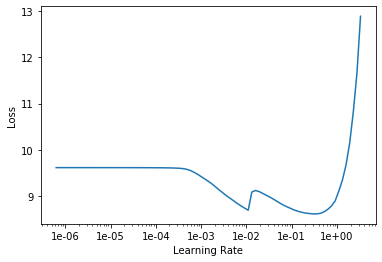

In [15]:
learn.recorder.plot()

In [16]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.712833,3.801982,0.689854,0.310145,44.789921,45:07
1,3.495445,3.612981,0.673845,0.326156,37.076435,44:49
2,3.416562,3.550838,0.667659,0.332342,34.842659,45:11
3,3.346702,3.473753,0.658722,0.341275,32.257648,45:09
4,3.269586,3.402409,0.649641,0.350360,30.036201,45:10
5,3.206794,3.321666,0.639204,0.360796,27.706499,45:08
6,3.124528,3.235740,0.627807,0.372192,25.425192,45:08
7,3.092082,3.157651,0.616111,0.383889,23.515293,45:11
8,2.963153,3.095485,0.606017,0.393983,22.097927,45:11
9,2.998470,3.079903,0.603129,0.396870,21.756315,45:09


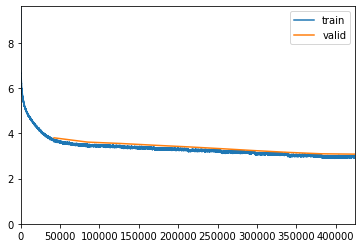

Better model found at epoch 0 with accuracy value: 0.31014543771743774.
Better model found at epoch 1 with accuracy value: 0.3261563181877136.
Better model found at epoch 2 with accuracy value: 0.3323418200016022.
Better model found at epoch 3 with accuracy value: 0.34127548336982727.
Better model found at epoch 4 with accuracy value: 0.3503599464893341.
Better model found at epoch 5 with accuracy value: 0.3607962131500244.
Better model found at epoch 6 with accuracy value: 0.3721919059753418.
Better model found at epoch 7 with accuracy value: 0.3838889002799988.
Better model found at epoch 8 with accuracy value: 0.393983393907547.
Better model found at epoch 9 with accuracy value: 0.3968702554702759.
CPU times: user 5h 51min 50s, sys: 1h 41min 8s, total: 7h 32min 59s
Wall time: 7h 31min 56s


In [17]:
%%time
learn.unfreeze()
wd = 0.01 
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit')])

Save the pretrained model and vocab:

In [18]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3[1] + '.pkl'))

### Backward

In [19]:
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit_bwd', bs=bs, backwards=True)

In [20]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [21]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 952 ms, sys: 68 ms, total: 1.02 s
Wall time: 1.02 s


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


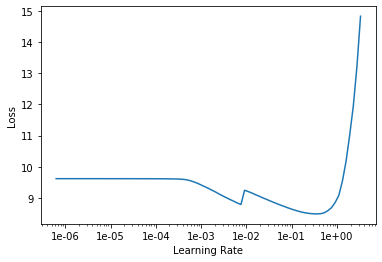

In [23]:
learn.recorder.plot()

In [24]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

wd = 0.01

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.759265,3.812161,0.645454,0.354546,45.248158,45:15
1,3.524330,3.643459,0.632401,0.367599,38.223717,45:16
2,3.399805,3.569191,0.624596,0.375404,35.487923,45:14
3,3.358356,3.492392,0.615690,0.384309,32.864567,48:06
4,3.298991,3.423204,0.607334,0.392666,30.667429,44:30
5,3.230762,3.344130,0.598109,0.401891,28.335854,44:15
6,3.139510,3.259253,0.586869,0.413130,26.030067,44:16
7,3.123008,3.175821,0.575663,0.424338,23.946394,44:10
8,3.007710,3.114435,0.566360,0.433641,22.520712,44:10
9,2.955673,3.098413,0.563313,0.436688,22.162729,44:18


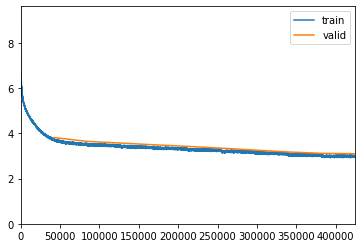

Better model found at epoch 0 with accuracy value: 0.35454609990119934.
Better model found at epoch 1 with accuracy value: 0.36759868264198303.
Better model found at epoch 2 with accuracy value: 0.3754040598869324.
Better model found at epoch 3 with accuracy value: 0.38430914282798767.
Better model found at epoch 4 with accuracy value: 0.39266595244407654.
Better model found at epoch 5 with accuracy value: 0.4018912613391876.
Better model found at epoch 6 with accuracy value: 0.4131302535533905.
Better model found at epoch 7 with accuracy value: 0.4243376851081848.
Better model found at epoch 8 with accuracy value: 0.43364080786705017.
Better model found at epoch 9 with accuracy value: 0.43668755888938904.
CPU times: user 5h 48min 48s, sys: 1h 42min 19s, total: 7h 31min 7s
Wall time: 7h 30min 9s


In [25]:
%%time
learn.unfreeze()
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit_bwd')])

In [26]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3_bwd[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3_bwd[1] + '.pkl'))

## Generate fake texts

**Note**: the architecture used for our Portuguese LM is based on 4 QRNN with about 46 millions of parameters. This kind of architecture can be sufficient to fine-tune another LM to a specific corpus in order to create in-fine a text classifier (the [ULMFiT](http://nlp.fast.ai/category/classification.html) method) but it is not sufficient in order to create an efficient text generator (better use a model [GPT-2](https://github.com/openai/gpt-2) or [BERT](https://github.com/google-research/bert)). More, the SentencePiece tokenizer used in this notebook implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) that can generate caracters from its vocabulary instead of words. 

In [9]:
%%time
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit', bs=bs)

CPU times: user 3.11 s, sys: 1.81 s, total: 4.92 s
Wall time: 13.7 s


In [10]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [11]:
# LM without pretraining
learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False)

In [12]:
# LM pretrained in English
learn_en = language_model_learner(data, AWD_LSTM, pretrained=True)

In [13]:
# LM pretrained in french
learn_pt = language_model_learner(data, AWD_LSTM, config=config, pretrained_fnames=lm_fns3)

In [14]:
TEXT = "Nadal venceu o torneio" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal venceu o torneio ▁comprar ▁relevante ▁cordas mila ▁lutadores ▁assumido fos ল velmente ▁conjunto ▁american ▁lentamente ▁empregada ▁extra เ anfitriã ⵙ ▁gonzaga ⊂ ̌ coli ▁feijão gi ▁útil ▁notável evolution my 20 ▁gen ▁subespécie ổ ▁cachoeira ▁natal nik ▁jornal ▁cartões ▁desportivo ▁grega ỏ sa ▁azulejos ▁habitat ▁energia fc ▁fazê 68 ▁reencontra ▁humorístico ▁mitchell ▁kris organiz ▁designar ▁castro ▁cerâmica ▁bob burg dos ▁usualmente ▁pessoas ▁principais ▁saudita ▁rom ▁escolhido ▁abandonou ▁patrimônio rid ib ▁ventos ▁banda ▁fim ▁dinamarquesa ን ▁divididos ▁apropriado carna ▁graves ▁vir ▁fm ខ far ▁cbf 提 wel ▁aclamação ├ 童 ▁vinda ▁alusão mun ▁bacia 工 ▁arrenda ▁biológica ▁marginal ▁cheio hí ▁chicago ▁daí 화 ▁parceira


In [15]:
TEXT = "Nadal venceu o torneio" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_en.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal venceu o torneio into the " big - screen " . a " ' cop - man ' game , " " a first - time " , is a one - game , game - to - day play . " a " as a game for the " bad man " , " you - do - it - you - do - it - me - to - do " game , " the first game " , is " the first game in the world " . a game in all four game , " the game " ,


In [16]:
TEXT = "Nadal venceu o torneio" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_pt.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal venceu o torneio ▁xxmaj ▁ ▁oficial ▁de ▁ , ▁em ▁seu ▁segundo ▁dia ▁no ▁dia ▁da ▁xxmaj ▁copa ▁xxmaj ▁ master s , ▁em ▁xxmaj ▁ las ▁xxmaj ▁vegas , ▁em ▁15 ▁de ▁xxmaj ▁abril ▁de ▁2016. ▁xxmaj ▁durante ▁a ▁temporada , ▁foi ▁o ▁primeiro ▁título ▁da ▁liga , ▁vencendo ▁o ▁xxmaj ▁ s pur s ▁por ▁9 zo s ▁por ▁3 ▁a ▁0 . ▁o ▁campeão ▁foi ▁o ▁ , ▁da ▁xxmaj ▁copa ▁do ▁xxmaj ▁mundo ▁de ▁xxmaj ▁ ty r rell , ▁onde ▁o ▁título ▁passou ▁a ▁ser ▁xxmaj ▁ s qua d . ▁a ▁xxup ▁ m l s ▁é
